In [23]:
from nltk.tree import Tree
from nltk.util import breadth_first
import os
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup


In [3]:
data_path = '../../data/MovieSummaries/corenlp_plot_summaries/sample/'

In [7]:
file_list = [item for item in os.listdir(data_path) if 'xml' in item]

In [36]:
file_list[0]

'25625475.xml'

In [27]:
f = open(os.path.join(data_path, file_list[0]), 'r').read()
xml = BeautifulSoup(f)

/anaconda3/envs/python36/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/envs/python36/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [32]:
sentences = xml.document.sentences.findAll('sentence')
for sent in sentences:
    print(sent.parse)
    break

In [35]:
len(sentences)

25

In [853]:
s = str(sentences[24].parse).replace('<parse>', '').replace('</parse>', '')
t = Tree.fromstring(s)

In [854]:
s

'(ROOT (S (ADVP (RB Afterwards)) (, ,) (NP (NNP Anna) (CC and) (NNP Kevin)) (VP (VBP are) (VP (VBN reunited))) (. .))) '

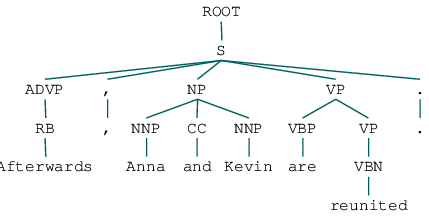

In [855]:
t

In [856]:
def find_np(sent):
    for c in breadth_first(sent, maxdepth = 2):
        # check if is a leave
        if not isinstance(c, str):
            if c.label() == 'NP':
                return c.leaves()

In [857]:
def find_vp(sent):
    vp = []
    for c in breadth_first(sent, maxdepth = 2):
        if not isinstance(c, str):
            if c.label() == 'VP':
                for cc in breadth_first(c, maxdepth = 3):
                    if not isinstance(cc, str):
                        # if a verb is in base form or past tense,
                        # return itself
                        # if it's in present form, find the be -ing form
                        if cc.label() in ['VB', 'VBD','VBG', 'VBN', 'VBP', 'VBZ']:
                            if not set(cc.leaves()).issubset(set(vp)):
                                vp.extend(cc.leaves())
                        if cc.leaves() == ['not']:
                            vp.extend(cc.leaves())

    return vp

In [858]:
def process_sentence(tree):
    subtrees = []
    np_vp = {}
    idx = 0
    
    # Remove root
    tree = list(tree.subtrees())[1]
    # Only take first level subtrees
    for c in breadth_first(tree, maxdepth = 2):
        subtrees.append(c)
    for st in subtrees[1:len(tree)]:
        # take care of nested sentences
        if st.label() == 'S' or st.label() == 'SBAR':
            k = find_np(st)
            v = find_vp(st)
            if k is not None and v is not None:
                k = ' '.join([item for item in k]) + str(idx)
                v = ' '.join([item for item in v])
                np_vp[k] = v
                # Differentiate potentially repeated subjects
                idx += 1
        else:
            if not isinstance(st, str):
                if st.label() == 'NP':
                    k = ' '.join([item for item in st.leaves()]) + str(idx)
                    idx += 1
                if st.label() == 'VP':
                    vp = []
                    for cc in breadth_first(st, maxdepth = 3):
                        if not isinstance(cc, str):
                            # if a verb is in base form or past tense,
                            # return itself
                            # if it's in present form, find the be -ing form
                            if cc.label() in ['VB', 'VBD','VBG', 'VBN', 'VBP', 'VBZ']:
                                if not set(cc.leaves()).issubset(set(vp)):
                                    vp.extend(cc.leaves())
                            if cc.leaves() == ['not']:
                                vp.extend(cc.leaves())
                        v = ' '.join([item for item in vp])
                    np_vp[k] = v
    return np_vp

In [859]:
process_sentence(t)

{'Anna and Kevin0': 'are reunited'}